# Aufgabe 2

In [ ]:
from enum import Enum
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt

In [ ]:
#%pip install imageio

   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/315.4 kB ? eta -:--:--
   --- ----------------------------------- 30.7/315.4 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/315.4 kB 409.6 kB/s eta 0:00:01
   -------------- ----------------------- 122.9/315.4 kB 654.9 kB/s eta 0:00:01
   -------------------- ----------------- 174.1/315.4 kB 700.2 kB/s eta 0:00:01
   ------------------------ ------------- 204.8/315.4 kB 734.2 kB/s eta 0:00:01
   -------------------------------------  307.2/315.4 kB 951.8 kB/s eta 0:00:01
   -------------------------------------- 315.4/315.4 kB 887.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
class Actions(Enum):
    right = 0
    up = 1
    left = 2
    down = 3


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2,
        # i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target_a": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target_b": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down", "right"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        i.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            Actions.right.value: np.array([1, 0]),
            Actions.up.value: np.array([0, 1]),
            Actions.left.value: np.array([-1, 0]),
            Actions.down.value: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        return {"agent": self._agent_location, "target_a": self._target_location_a, "target_b": self._target_location_b}

    def _get_info(self):
        return {
            "distance_a": np.linalg.norm(
                self._agent_location - self._target_location_a, ord=1
            ),
            "distance_b": np.linalg.norm(
                self._agent_location - self._target_location_b, ord=1
            )
        }

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not
        # coincide with the agent's location
        self._target_location_a = np.array([1, 0])
        self._target_location_b = np.array([3, 0])

        while np.array_equal(self._target_location_a, self._agent_location) or np.array_equal(self._target_location_a, self._agent_location):
            self._agent_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        reward = 0  # Binary sparse rewards
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        unclipped_loc = self._agent_location
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        if np.array_equal(unclipped_loc, self._agent_location):
            reward = -1
        elif np.array_equal(self._agent_location, self._target_location_a):
            self._agent_location = np.array([1, 4])
            reward = 10
        elif np.array_equal(self._agent_location, self._target_location_b):
            self._agent_location = np.array([3, 2])
            reward = 5
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, False, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location_a,
                (pix_square_size, pix_square_size),
            ),
        )
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location_b,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [12]:
from gymnasium.envs.registration import register

register(
    id="Grid",
    entry_point=GridWorldEnv,
)
env = gym.make("Grid", size=5, render_mode="rgb_array")

c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment Grid already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [13]:
def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

    return im


def save_random_agent_gif(env):
    frames = []
    for i in range(1):
        state = env.reset()
        for t in range(500):
            action = env.action_space.sample()

            frame = env.render()
            frames.append(_label_with_episode_number(frame, episode_num=i))

            state, _, done, _, _ = env.step(action)
            if done:
                break

    env.close()

    imageio.mimwrite(os.path.join('./videos/', 'random_agent.gif'), frames, fps=60)


#save_random_agent_gif(env)

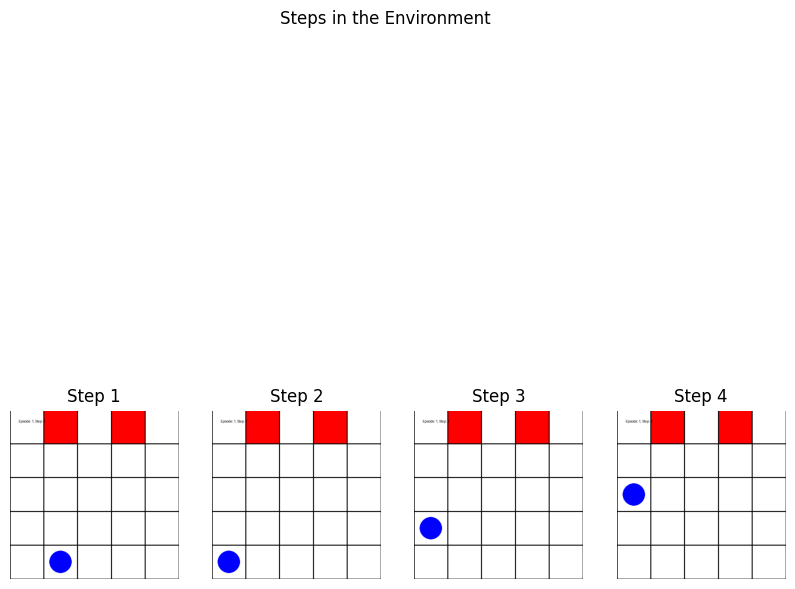

In [14]:
env = gym.make("Grid", size=5, render_mode="rgb_array")

def label_frame_with_step(frame, episode_num, step_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    text_color = (255, 255, 255) if np.mean(im) < 128 else (0, 0, 0)
    drawer.text((im.size[0] / 20, im.size[1] / 18), f'Episode: {episode_num+1}, Step: {step_num+1}', fill=text_color)
    return im

def capture_random_steps(env, episode_num=0, steps_to_capture=4):
    env.reset()
    captured_frames = []
    for step_num in range(steps_to_capture):
        action = env.action_space.sample()
        frame = env.render() 
        labeled_frame = label_frame_with_step(frame, episode_num, step_num)
        captured_frames.append(labeled_frame)
        _, _, done, _, _ = env.step(action)
        if done:
            break
    env.close()
    return captured_frames

frames = capture_random_steps(env)
plt.figure(figsize=(10, 10))
for i, frame in enumerate(frames):
    plt.subplot(1, len(frames), i + 1)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f"Step {i + 1}")
plt.suptitle("Steps in the Environment")
plt.show()